# Fine tuning classification for justification

We will fine-tune an ada classifier to distinguish between justification and non-justification posts

In [ ]:
!pip install openai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 14.4 MB/s eta 0:00:00


In [ ]:

import pandas as pd
import openai



 ## Data exploration
 Load data from Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
Just = pd.read_csv('/content/drive/MyDrive/delib_data/data-gpt/CLAPTON_Justification_fulldata.csv',  sep='\t' ,encoding="UTF-8")


Mounted at /content/drive


In [ ]:
len_all, len_positive, len_not = len(Just), len([e for e in Just.completion if e == "Justification"]), len([e for e in Just.completion if e == "0"])
print(f"Total examples: {len_all}, Positive examples: {len_positive}, Negative examples: {len_not}")

Total examples: 29803, Positive examples: 12736, Negative examples: 9275


One sample from the Constructiveness training set can be seen above. We see that the data is quite skewed.

## Data Preparation
We transform the dataset into a pandas dataframe, with a column for prompt and completion. The prompt contains the email from the mailing list, and the completion is a name of the sport, either hockey or baseball. For demonstration purposes only and speed of fine-tuning we take only 300 examples. In a real use case the more examples the better the performance.

In [ ]:
Just.head()
Just = Just.dropna(subset=['completion'])
Just.completion.unique()

array(['Justification', '0'], dtype=object)

We save the dataset as a jsonl file.

In [ ]:
Just.to_json("/content/drive/MyDrive/delib_data/data-gpt/Just.jsonl", orient='records', lines=True)
Just.to_json("Just.jsonl", orient='records', lines=True)

### Data Preparation tool
We can now use a data preparation tool which will suggest a few improvements to our dataset before fine-tuning. Before launching the tool we update the openai library to ensure we're using the latest data preparation tool. We additionally specify `-q` which auto-accepts all suggestions.

In [ ]:
#!pip install --upgrade openai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!openai tools fine_tunes.prepare_data -f Just.jsonl -q

Analyzing...

- Your file contains 22011 prompt-completion pairs
- Based on your data it seems like you're trying to fine-tune a model for classification
- For classification, we recommend you try one of the faster and cheaper models, such as `ada`
- For classification, you can estimate the expected model performance by keeping a held out dataset, which is not used for training
- There are 368 duplicated prompt-completion sets. These are rows: [93, 94, 95, 96, 97, 98, 99, 100, 325, 326, 327, 328, 329, 1642, 1643, 1644, 2830, 3137, 3138, 3139, 3140, 3141, 3142, 3143, 3144, 3580, 3581, 3582, 3900, 3901, 3902, 4726, 4823, 4824, 4825, 5642, 5694, 5701, 5702, 5703, 5704, 5705, 5706, 5707, 5708, 5709, 5710, 5717, 5721, 5783, 5788, 5793, 5794, 5795, 5797, 5801, 5832, 5837, 5839, 5847, 5877, 5882, 5912, 5915, 5918, 5919, 5920, 5930, 5931, 5932, 5933, 5934, 5953, 5973, 5990, 5992, 6093, 6246, 6323, 6436, 6485, 6535, 6594, 6675, 6699, 6729, 6779, 6818, 6862, 6865, 6907, 6974, 6976, 6984, 6996, 7

The tool helpfully suggests a few improvements to the dataset and splits the dataset into training and validation set.

A suffix between a prompt and a completion is necessary to tell the model that the input text has stopped, and that it now needs to predict the class. Since we use the same separator in each example, the model is able to learn that it is meant to predict either baseball or hockey following the separator.
A whitespace prefix in completions is useful, as most word tokens are tokenized with a space prefix.
The tool also recognized that this is likely a classification task, so it suggested to split the dataset into training and validation datasets. This will allow us to easily measure expected performance on new data.

## Fine-tuning
The tool suggests we run the following command to train the dataset. Since this is a classification task, we would like to know what the generalization performance on the provided validation set is for our classification use case. The tool suggests to add `--compute_classification_metrics --classification_positive_class " baseball"` in order to compute the classification metrics.

We can simply copy the suggested command from the CLI tool. We specifically add `-m ada` to fine-tune a cheaper and faster ada model, which is usually comperable in performance to slower and more expensive models on classification use cases.

In [ ]:
!openai -k "APIKEY" api fine_tunes.create -t "Just_prepared_train (1).jsonl" -v "Just_prepared_valid (1).jsonl" --compute_classification_metrics --classification_positive_class " Justification" -m ada


Upload progress: 100% 5.42M/5.42M [00:00<00:00, 3.28Git/s]
Uploaded file from Just_prepared_train (1).jsonl: file-1K4cAfUpnM7bV6zKbxd0eWJR
Upload progress: 100% 260k/260k [00:00<00:00, 437Mit/s]
Uploaded file from Just_prepared_valid (1).jsonl: file-alvUrXTtSYVsb1TfIcQxf1pR
Created fine-tune: ft-ta6T9YzjvHAuFfzOjImHHkkR
Streaming events until fine-tuning is complete...

(Ctrl-C will interrupt the stream, but not cancel the fine-tune)
[2023-04-28 12:47:11] Created fine-tune: ft-ta6T9YzjvHAuFfzOjImHHkkR

Stream interrupted (client disconnected).
To resume the stream, run:

  openai api fine_tunes.follow -i ft-ta6T9YzjvHAuFfzOjImHHkkR



In [ ]:
!openai -k "API KEY" api fine_tunes.follow -i <modelid> ##just clean


[2023-04-28 12:47:11] Created fine-tune: ft-ta6T9YzjvHAuFfzOjImHHkkR

Stream interrupted (client disconnected).
To resume the stream, run:

  openai api fine_tunes.follow -i ft-ta6T9YzjvHAuFfzOjImHHkkR



The model is successfully trained in about ten minutes. We can see the model name is `ada:ft-openai-2021-07-30-12-26-20`, which we can use for doing inference.

### [Advanced] Results and expected model performance
We can now download the results file to observe the expected performance on a held out validation set.

In [ ]:
!openai -k "API KEY" api fine_tunes.results -i <modelid> > result.csv

In [ ]:
results = pd.read_csv('result.csv')
results[results['classification/accuracy'].notnull()].tail(1)

step  elapsed_tokens  elapsed_examples  training_loss  \
3510  3511        32780768            112352       0.005671   

      training_sequence_accuracy  training_token_accuracy  validation_loss  \
3510                         1.0                      1.0              NaN   

      validation_sequence_accuracy  validation_token_accuracy  \
3510                           NaN                        NaN   

      classification/accuracy  classification/weighted_f1_score  
3510                    0.886                            0.8783

The accuracy reaches 99.6%. On the plot below we can see how accuracy on the validation set increases during the training run.

<Axes: >

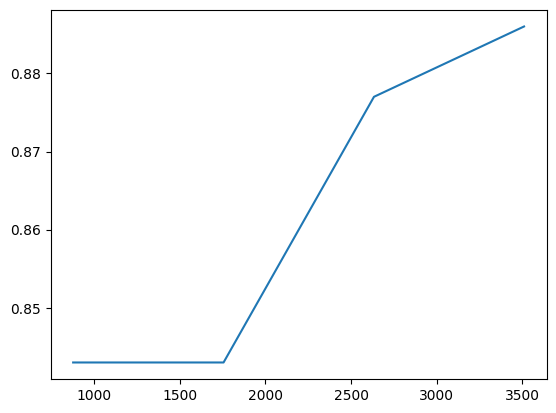

In [ ]:
results[results['classification/accuracy'].notnull()]['classification/accuracy'].plot()